# 데이터 분석과 기계학습 - 201704235 이형주
### 시계열 데이터를 사용하여 세 모델의 평가 지표를 통한  제주도 방문객 수요 예측 연구
### 시계열 예측 모델인 ARIMA 모델
### 딥러닝 기법인 LSTM 모델 
### 페이스북에서 만든 시계열 예측 Library Prophet

### 0. 사용 라이브러리 불러오기

In [28]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import statsmodels.tsa.seasonal as tsa
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import backend as K
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from pmdarima.arima import ndiffs

### 1. 데이터 불러오기

### 데이터 출처:http://www.visitjeju.or.kr/main.do
### 2001년부터 2021년까지 월 별로 정리된 제주도 입도 관광객 통계 데이터

In [12]:
df = pd.read_csv('visitors.csv', encoding = 'utf-8')
df

,visitors
0,305666
1,262896
2,297281
3,397188
4,431365
...,...
247,974194
248,872396
249,1222094
250,1204344


In [13]:
# 시계열 데이터로 만들기 위해 수집된 데이터의 범위인 2001년부터 2021년까지 1달 마다의 timestamp 객체 생성
series_ts  = pd.date_range("2001-1", "2021-12", freq="MS")
series_ts

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', length=252, freq='MS')

In [14]:
# date time 으로 만든 객체를 데이터 프레임에 insert 한다.
df.insert(0, 'Date', series_ts)

In [15]:
df.head()

,Date,visitors
0,2001-01-01,305666
1,2001-02-01,262896
2,2001-03-01,297281
3,2001-04-01,397188
4,2001-05-01,431365


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      252 non-null    datetime64[ns]
 1   visitors  252 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.1 KB


## 2. 데이터 EDA 및 전처리

## [ 시계열 데이터의 특징 ]


동일한/ 고정된 간격의 날짜-시간 index 

중복 없고, 빠진 것도 없는 날짜-시간 index 

시간 순서대로 정렬 

In [17]:
df.index = df['Date']
df.set_index('Date', inplace = True)
df.head()

,visitors
Date,
2001-01-01,305666
2001-02-01,262896
2001-03-01,297281
2001-04-01,397188
2001-05-01,431365


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2001-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   visitors  252 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


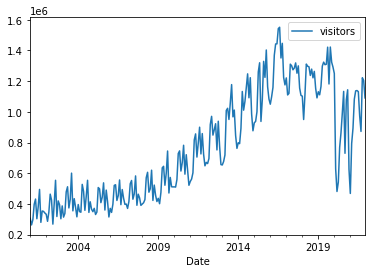

In [9]:
df.plot()
plt.show()


* 시계열 분해
     - Trend: 데이터가 장기적으로 증가하거나 감소할 때, 추세(trend) 가 존재한다.
     - Seasonality: 해마다 어떤 특정한 때나 1주일마다 특정 요일에 나타나는 것 같은 계절성 요인이 시계열에 영향을 줄 때 계절(seasonality) 패턴이 나타난다.
     - Residiual: 고정된 빈도가 아닌 형태로 증가나 감소하는 모습을 보일 때 주기(cycle)가 나타납니다.

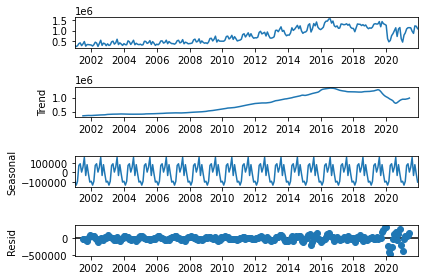

In [10]:
#시계열 모델 생성
model_series = tsa.seasonal_decompose(df, model = 'additive')
#모델 시각화
fig = model_series.plot()
plt.show()

## 3. 모델 생성 및 검증

### 1) ARIMA 모델

#### 시계열 데이터 기반 분석 기법
과거 지식이나 경험을 바탕으로 한 행동에 따라 데이터가 움직이고 있음을 기초로 한다.

<AxesSubplot:xlabel='Date'>

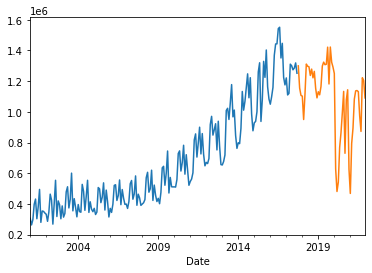

In [18]:
y_train = df['visitors'][:int(0.8*len(df))]
y_test = df['visitors'][int(0.8*len(df)):]
y_train.plot()
y_test.plot()

In [29]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [30]:
import pmdarima as pm
# ARIMA 모델 생성
model = pm.auto_arima (y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5231.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5218.281, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5209.900, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5229.945, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5202.901, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5200.358, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5202.902, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5200.752, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5198.010, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5197.420, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5201.033, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5180.103, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

In [20]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2584.052
Date:                Mon, 12 Dec 2022   AIC                           5180.103
Time:                        18:28:35   BIC                           5199.893
Sample:                    01-01-2001   HQIC                          5188.112
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8785.7994   3625.220      2.424      0.015    1680.499    1.59e+04
ar.L1         -0.9981      0.005   -210.289      0.000      -1.007      -0.989
ma.L1          0.9243      0.061     15.088      0.0

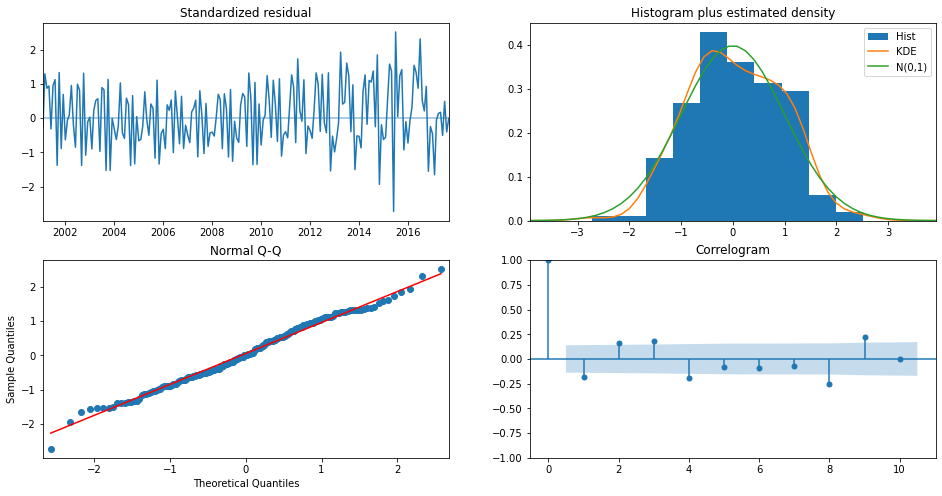

In [21]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 
        , return_conf_int=True)              
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [23]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [32]:
pd.DataFrame({"test": y_test, "pred": y_pred}).head()

,test,pred
Date,,
2017-10-01,1299582,1.322528e+06
2017-11-01,1154632,1.272706e+06
2017-12-01,1106997,1.218310e+06
2018-01-01,1102378,1.174095e+06
2018-02-01,949909,1.229521e+06


In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
            # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

    
fig.update_layout(height=400, width=1000, title_text="ARIMA(1,1,3)모형")
fig.show()

In [49]:
mae = mean_absolute_error(y_pred, y_test)
print('MAE score:' , mae)

rmse = np.sqrt(np.mean(y_pred - y_test) ** 2)
print('RMSE score:' ,rmse)

r2 = (r2_score(y_test, y_pred))
print('R-squared score:', r2)

MAE score: 125796.34136024352
RMSE score: 14305.407418350615
R-squared score: 0.4908542793893388


### 2) LSTM

In [520]:
df.shape

(252, 1)

In [521]:
data = df.filter(['visitors'])
npdataset = data.values

training_data_length = math.ceil(len(npdataset) * 0.8)

# min max scaler 적용
mmscaler = MinMaxScaler(feature_range = (0,1))
scaled_data = mmscaler.fit_transform(npdataset)
scaled_data

array([[0.033196],
       [0.      ],
       [0.026688],
       [0.104231],
       [0.130757],
       [0.031308],
       [0.091628],
       [0.179608],
       [0.012988],
       [0.070484],
       [0.068384],
       [0.060116],
       [0.053807],
       [0.01818 ],
       [0.065516],
       [0.155681],
       [0.125512],
       [0.003983],
       [0.108017],
       [0.225799],
       [0.042433],
       [0.121392],
       [0.102214],
       [0.031103],
       [0.096129],
       [0.039406],
       [0.058026],
       [0.167146],
       [0.193013],
       [0.085913],
       [0.128767],
       [0.261927],
       [0.071168],
       [0.132787],
       [0.089863],
       [0.040826],
       [0.103067],
       [0.067457],
       [0.0641  ],
       [0.205024],
       [0.170064],
       [0.073828],
       [0.143995],
       [0.225795],
       [0.063273],
       [0.116987],
       [0.079236],
       [0.066983],
       [0.083844],
       [0.052615],
       [0.065168],
       [0.189083],
       [0.18

In [280]:
train_data = scaled_data[0:training_data_length, :]

x_train = []
y_train = []
trainingdatasize = len(train_data)
for i in range(100, trainingdatasize):
    x_train.append(train_data[i-100: i, 0])
    y_train.append(train_data[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(102, 100, 1)
(102,)


In [253]:
K.clear_session()
# model 생성
model =Sequential()

model.add(LSTM(100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences = False))
model.add(Dense(25, activation = 'ReLU'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [268]:
history = model.fit(x_train, y_train, batch_size =2 , epochs = 25)

Epoch 1/25
51/51 [==============================] - 2s 37ms/step - loss: 0.0099
Epoch 2/25
51/51 [==============================] - 2s 37ms/step - loss: 0.0111
Epoch 3/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0124
Epoch 4/25
51/51 [==============================] - 2s 37ms/step - loss: 0.0085
Epoch 5/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0085
Epoch 6/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0081
Epoch 7/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0081
Epoch 8/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0066
Epoch 9/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0053
Epoch 10/25
51/51 [==============================] - 2s 37ms/step - loss: 0.0057
Epoch 11/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0068
Epoch 12/25
51/51 [==============================] - 2s 36ms/step - loss: 0.0056
Epoch 13/25
51/51 [==================

In [269]:
test_data = scaled_data[training_data_length - 100:, :]

x_test = []
y_test = npdataset[training_data_length:, :]

for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [270]:
y_pred = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred)

2/2 [==============================] - 0s 18ms/step


In [271]:
mae = mean_absolute_error(y_pred, y_test)
print('MAE score:' ,mae)

rmse = np.sqrt(np.mean(y_pred - y_test) ** 2)
print('RMSE score:' , rmse)

r2 = (r2_score(y_test, y_pred))

print('r2 score :', r2)

MAE score:153747.2
RMSE score:101409.0
r2 score : 0.16209275490289277


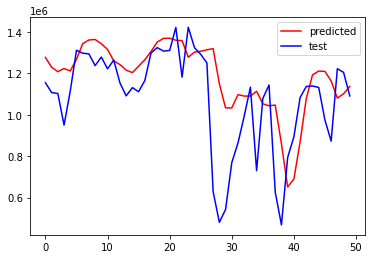

In [272]:
plt.plot(y_pred, 'r', label = 'predicted')
plt.plot(y_test, 'b', label = 'test')
plt.legend()

### 3) Prophet

In [206]:
from prophet import Prophet

df = pd.read_csv('visitors.csv', encoding = 'utf-8')
df

,visitors
0,305666
1,262896
2,297281
3,397188
4,431365
...,...
247,974194
248,872396
249,1222094
250,1204344


In [207]:
series_ts  = pd.date_range("2001-1", "2021-12", freq="MS")
series_ts

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', length=252, freq='MS')

In [208]:
df.insert(0, 'Date', series_ts)

In [209]:
df.columns = ['ds','y']

In [210]:
df

,ds,y
0,2001-01-01,305666
1,2001-02-01,262896
2,2001-03-01,297281
3,2001-04-01,397188
4,2001-05-01,431365
...,...,...
247,2021-08-01,974194
248,2021-09-01,872396
249,2021-10-01,1222094
250,2021-11-01,1204344


In [211]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [213]:
future_dates = m.make_future_dataframe(periods=12, freq='MS')
future_dates

,ds
0,2001-01-01
1,2001-02-01
2,2001-03-01
3,2001-04-01
4,2001-05-01
...,...
259,2022-08-01
260,2022-09-01
261,2022-10-01
262,2022-11-01


In [215]:
# 예측값 생성
forecast = m.predict(future_dates)

# 모델 피팅값 확인
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

C:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\ProgramData\Anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
0,2001-01-01,2.250339e+05,96359.279099,3.642641e+05
1,2001-02-01,2.421206e+05,108476.430812,3.672912e+05
2,2001-03-01,2.362304e+05,102721.316410,3.639259e+05
3,2001-04-01,4.049368e+05,263142.740034,5.376733e+05
4,2001-05-01,4.302371e+05,294911.406747,5.682039e+05
...,...,...,...,...
259,2022-08-01,1.108529e+06,982421.996575,1.254966e+06
260,2022-09-01,9.170627e+05,796934.587203,1.053834e+06
261,2022-10-01,1.035510e+06,906542.820505,1.171648e+06
262,2022-11-01,9.274552e+05,792684.452305,1.058322e+06


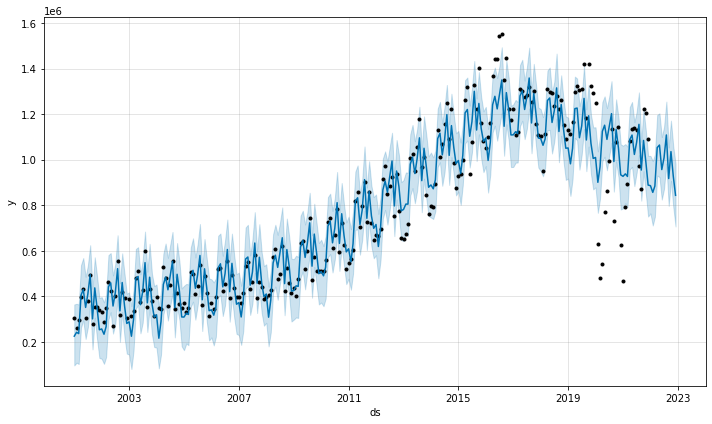

In [216]:
m.plot(forecast)
plt.show()


In [243]:
# 모델 예측 정확도 평가 
y_true = df['y'][0:251].values
y_pred = forecast['yhat'][0:251].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE score:' ,mae)

rmse = np.sqrt(np.mean(y_pred - y_true) ** 2)
print('RMSE score:' , rmse)

r2 = (r2_score(y_true, y_pred))

print('r2 score :', r2)

MAE score: 68056.52006540495
RMSE score: 985.3602636473214
r2 score : 0.9125761144289248


# 4. Conclusion

### ARIMA평가 점수
##### MAE score: 125796.34
##### RMSE score: 14305.41
##### r2 score : 0.490

### LSTM 평가 점수
##### MAE score: 153747.2
##### RMSE score: 101409.0
##### r2 score : 0.162


### Prophet 평가 점수
##### MAE score: 68056.52
##### RMSE score: 985.36
##### r2 score : 0.913